In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier
import tensorflow.keras.metrics as metrics

In [ ]:
telemetry = pd.read_csv('/content/drive/MyDrive/pred_maintenance_data /PdM_telemetry.csv')
failures = pd.read_csv('/content/drive/MyDrive/pred_maintenance_data /PdM_failures.csv')
machines = pd.read_csv('/content/drive/MyDrive/pred_maintenance_data /PdM_machines.csv')
failures['failure']=1

#combine data into 1 csv
data = telemetry.merge(machines, on='machineID', how='left')
data = data.merge(failures, on=['machineID', 'datetime'], how='left')

# where failure is NaN, put 0(boolean type)
data.fillna(0, inplace=True)

data.head(100)

,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,0.0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,0.0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18,0.0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18,0.0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18,0.0
...,...,...,...,...,...,...,...,...,...
95,2015-01-05 05:00:00,1,177.510419,469.787301,100.498426,59.577251,model3,18,0.0
96,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,model3,18,1.0
97,2015-01-05 07:00:00,1,155.511452,498.398435,103.068134,33.270415,model3,18,0.0
98,2015-01-05 08:00:00,1,172.439821,392.124959,108.135159,39.477497,model3,18,0.0


In [ ]:
# Feature selection (Done manually)
features = ['pressure', 'vibration', 'age']
target = 'failure'

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Sort by datetime for all machines
data = data.sort_values(by='datetime')

In [ ]:
# Create time-series sequences for LSTM
def create_sequences(data, target_col, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length][features].values)
        # Convert target value to 0 if it's not 1
        target_val = data.iloc[i+sequence_length][target_col]
        y.append(1 if target_val == 1 else 0)
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(data, target)

In [ ]:
# Train test split with 80:20 values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert y_train and y_test to numeric type (easier for processing)
y_train = y_train.astype(int)
y_test = y_test.astype(int)
# Compute class weights to penalize false negatives
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Using sklearn Multi-Layer Perceptron model as a baseline model for comparison
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import learning_curve
MLP_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', random_state=42)
X_train_MLP = X_train.reshape(X_train.shape[0], -1)
X_test_MLP = X_test.reshape(X_test.shape[0], -1)
MLP_model.fit(X_train_MLP, y_train)
MLP_pred = MLP_model.predict(X_test_MLP)
print(classification_report(y_test, MLP_pred))
print(accuracy_score(y_test, MLP_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175075
           1       0.00      0.00      0.00       152

    accuracy                           1.00    175227
   macro avg       0.50      0.50      0.50    175227
weighted avg       1.00      1.00      1.00    175227

0.999041243643959


In [ ]:
from keras.regularizers import l2
# Define LSTM Model with L2 regularization
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, len(features)),
         kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile model, lr optimizer = adam, binary loss minimizer and metrics to track progress over epochs
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall', metrics.BinaryAccuracy])

# Train model with class weights, with bathc size = 32 and 8 epochs
history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight_dict)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
21904/21904 ━━━━━━━━━━━━━━━━━━━━ 365s 16ms/step - accuracy: 0.7845 - binary_accuracy: 0.7845 - loss: 0.7313 - recall: 0.1818 - val_accuracy: 0.9991 - val_binary_accuracy: 0.9991 - val_loss: 0.6809 - val_recall: 0.0000e+00
Epoch 2/8
21904/21904 ━━━━━━━━━━━━━━━━━━━━ 376s 16ms/step - accuracy: 0.7600 - binary_accuracy: 0.7600 - loss: 0.6823 - recall: 0.2273 - val_accuracy: 0.9991 - val_binary_accuracy: 0.9991 - val_loss: 0.6814 - val_recall: 0.0000e+00
Epoch 3/8
21904/21904 ━━━━━━━━━━━━━━━━━━━━ 361s 15ms/step - accuracy: 0.8913 - binary_accuracy: 0.8913 - loss: 0.6721 - recall: 0.0906 - val_accuracy: 8.6745e-04 - val_binary_accuracy: 8.6745e-04 - val_loss: 0.7076 - val_recall: 1.0000
Epoch 4/8
21904/21904 ━━━━━━━━━━━━━━━━━━━━ 381s 15ms/step - accuracy: 0.4256 - binary_accuracy: 0.4256 - loss: 0.6881 - recall: 0.5401 - val_accuracy: 8.6745e-04 - val_binary_accuracy: 8.6745e-04 - val_loss: 0.7048 - val_recall: 1.0000
Epoch 5/8
21904/21904 ━━━━━━━━━━━━━━━━━━━━ 395s 16ms/step - accu

In [ ]:
 # Make prediction probability with LSTM, not the final prediction
y_prob = model.predict(X_test)

# Thresholding to predict failure (Binary Activation function)
y_pred = (y_prob > 0.6).astype(int)
from sklearn.metrics import classification_report, accuracy_score

# Print classification report and accuracy
print(classification_report(y_test, y_pred))
print("Accuracy : ", accuracy_score(y_test, y_pred))

# Store results in a DataFrame
test_results = pd.DataFrame({
    'datetime': data['datetime'].iloc[-len(y_test):],
    'Actual': y_test,
    'Predicted': y_pred.flatten(),
    'Probability': y_prob.flatten()
})

5476/5476 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175075
           1       0.00      0.00      0.00       152

    accuracy                           1.00    175227
   macro avg       0.50      0.50      0.50    175227
weighted avg       1.00      1.00      1.00    175227

Accuracy :  0.9991325537731057


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


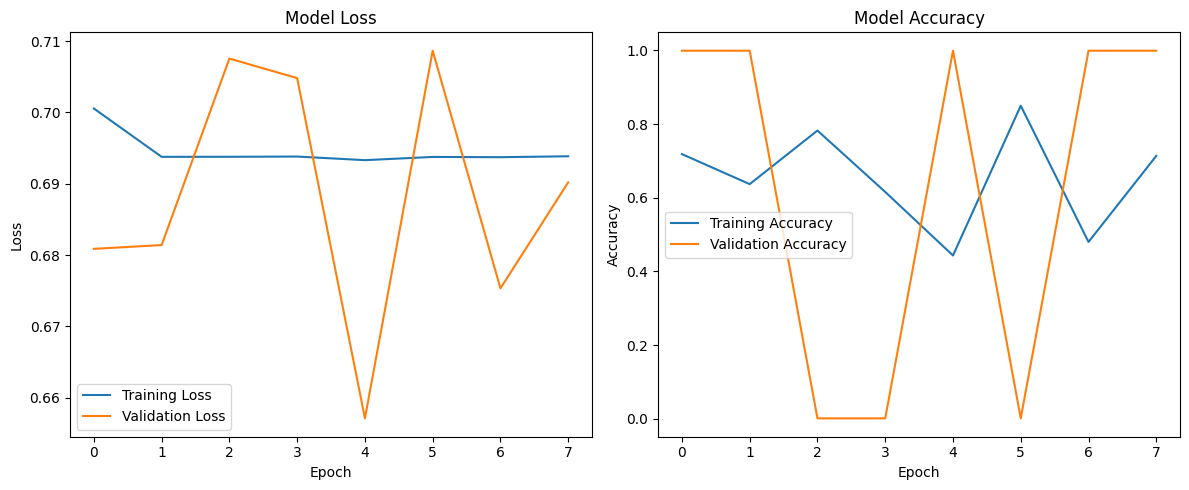

In [ ]:

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


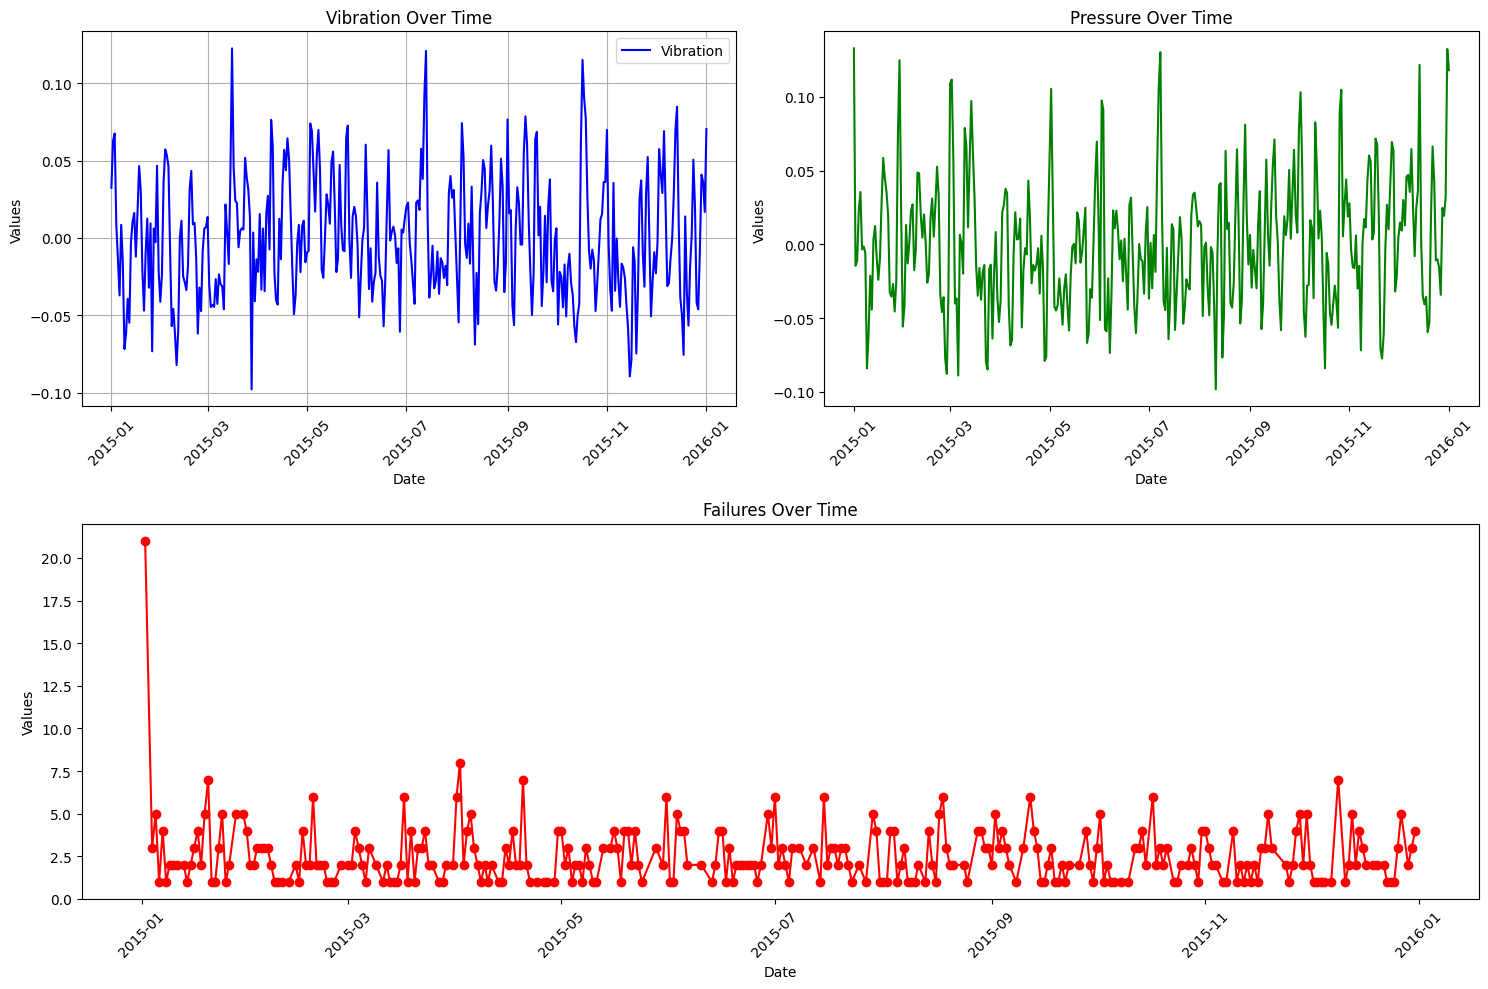

In [ ]:
df = data
#Convert datetime into pandas datetime format
df['datetime'] = pd.to_datetime(df['datetime'])
#Removing Model col for ease of plotting
df = df.drop(columns=['model'])

# Filtering the df to include only entries with failure = 1.0 to plot failure over time
df_failures = df[df['failure'] == 1.0]

#Grouping df entries by datetime for plotting of pressure and vibration (multiple machines)
df_grouped = df.groupby(df['datetime'].dt.date).mean()

# Counting failures over time (grouped by date)
df_failures_count = df_failures.groupby(df_failures['datetime'].dt.date).size()

plt.figure(figsize=(15, 10))

# Plot failures over time
plt.subplot(2, 1, 2)
plt.plot(df_failures_count.index, df_failures_count.values, marker='o', label='Failures', color='red')
plt.title('Failures Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)

# Plot pressure over time
plt.subplot(2,2,2)
plt.plot(df_grouped.index, df_grouped['pressure'], label='Pressure', color='green')
plt.title('Pressure Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)

# Plot vibration over time
plt.subplot(2,2,1)
plt.plot(df_grouped.index, df_grouped['vibration'], label='Vibration', color='blue')
plt.title('Vibration Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)

# Adding grid and legend
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()